In [130]:
import autograd.numpy as np
from autograd import grad
from autograd.numpy import linalg
from autograd.numpy.random import multivariate_normal, normal
%matplotlib inline
from matplotlib import pyplot as plt

In [131]:
#initialise parameters
N = 10 # Number of iterations
M = 2 # dimensionality of state
L = 2 # dimensionality of output
e = 1e-5 # convergence condition

#Kalman Parameters, linear motion estimation
t_s = 0.1 #sample period
s_p = 1 #process noise variance

A = np.asarray([[1,t_s],[0,1]]) # state transition
B = np.asarray([[np.power(t_s,2)/2],[t_s]]) # noise matrix
C = np.asarray([0,1]) # observation matrix
Q = np.asarray([[s_p/64,s_p/16],[s_p/16,s_p/4]]) # Process noise Covariance
R = np.asarray([[0.01,0.005],[0.005,0.01]]) # Measurement Noise

u = normal(0,s_p,1).T
z = np.asarray([[1],[1]]) + np.dot(B,u) # initial state
v = multivariate_normal(np.zeros(M),R).T #measurement noise
y = np.dot(C,z) + v #initial output

#PDMM Parameters
Z = z # state history
U = u # noise history
Y = y # output history
# E = linalg.inv(np.block([[Q,np.zeros(M,M)],[np.zeros([M,M]),R]]))
p = 0.001 #step size

In [132]:
def ml_gradient_desc():
    #initial guesses
    z = normal(0,1,[M,1])
    u = normal(0,1,[M,1])
    step_dir = grad(ml_cost)
    error = 1
    #iterate till desired precision reached
    while error > e:
        #perform gradient descent
        x = step_dir(z,u)
        error = linalg.norm(p*x)
        z = z + p*x[:M] 
        u = u + p*x[M:]
    
    #create next estimate
    z_next = np.dot(A,z) + np.dot(B,u)
    return z_next, z, u

In [133]:
def ml_cost(z,u):
    x = np.block([u,y-np.dot(C,z)])
    return np.dot(np.dot(x,E),x.T)

In [134]:
# Run kalman simulation
for i in range(N):
    u = normal(0,s_p,1).T
    v = multivariate_normal(np.zeros(M),R).T
    z = np.dot(A,z) + np.dot(B,u)
    y = np.dot(C,z) + v
    
    Z = np.append(Z,z,axis=1)
    U = np.append(U,u)
    Y = np.append(Y,y)
    
    #perform PDMM estimation
#     z_new, ml_gradient_desc()
    #perform Kalman estimation

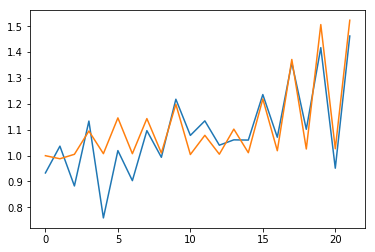

In [137]:
plt.plot(Y)
plt.plot(Z[1,:])